This Jupytr notebook 

In [94]:
# !/bin/sh

# Install required Python packages
!python3 -m pip install -r requirements.txt

In [95]:
import requests
import builtins
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

Constants for file locations and column mappings used in processing GHCND climate data.

In [96]:

# Constants to navigate the data
STATE_CODE = "IA" # state code according to ghcnd-states.
# Sample row: "CA001039040  50.0333 -126.8167   91.0 BC ZEBALLOS IRON MINES"
STATION_FILE_COLUMNS_MAPPING = {
    "ID": [0, 11],
    "STATE": [38, 40],
}
STATION_DATA_COLUMN_MAPPING = {
    "ID": [0, 11],
    "YEAR": [11, 15],
    "MONTH": [15, 17],
    "ELEMENT_TYPE": [17, 21],
    "ELEMENT": [21, 26],
}

# For downloading data
GHCND_DOWNLOAD_LOCATION = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{}.dly" # location to download data files, format with station ID
GHCND_STATION_FILE_LOCATION = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt" # location to download ghcnd station file

# For predownloaded data
GHCND_BASE_LOCATION = "./data/climate_data" # base location of ghcnd data files
STATION_FILE = f"{GHCND_BASE_LOCATION}/raw_data/ghcnd-stations.txt" # ghcnd station file
GHCND_OUTPUT_FILE = f"{GHCND_BASE_LOCATION}/processed/ghcnd-{STATE_CODE}-data.csv" # output file for state data


Pull data from DLV files

In [105]:
def load_or_download_file(url, local_path):
    """Load a file from local path or download it if not present."""
    try:
        f = builtins.open(local_path, 'r')
        file_data = (line for line in f)
        df = pd.DataFrame(file_data, columns=["line"])
        f.close()
    except FileNotFoundError:
        response = requests.get(url)
        response.raise_for_status()
        data = response.text
        file_path = Path(local_path)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with builtins.open(local_path, 'w') as f:
            f.write(data)

        f = builtins.open(local_path, 'r')
        file_data = (line for line in f)
        df = pd.DataFrame(file_data, columns=["line"])
        f.close()

    return df

def dlv_to_filtered_df(df):
    """
    Convert a DLV file to a pandas DataFrame.
    1. Load entire DLV file into a DataFrame. With 1 single row per observation.
    2. Split the first column into multiple columns based on fixed width.
    3. Create dataframe with just the columns defined in STATION_DATA_COLUMN_MAPPING
    4. Filter for ELEMENT = TMAX or TMIN by creating two separate dataframes and merging them on MONTH and YEAR.
    5. Calculate TAVG as the average of TMAX and TMIN.
    6. Return the final DataFrame.
    """
    for col_name, (start, end) in STATION_DATA_COLUMN_MAPPING.items():
        df[col_name] = df["line"].str[start:end].str.strip()
    df = df[list(STATION_DATA_COLUMN_MAPPING.keys())]

    tmax_df = df[df["ELEMENT_TYPE"] == "TMAX"][["YEAR", "MONTH", "ID", "ELEMENT"]].rename(columns={"ELEMENT": "TMAX"})
    tmax_df = tmax_df[tmax_df["TMAX"] != '-9999']

    tmin_df = df[df["ELEMENT_TYPE"] == "TMIN"][["YEAR", "MONTH", "ID", "ELEMENT"]].rename(columns={"ELEMENT": "TMIN"})
    tmin_df = tmin_df[tmin_df["TMIN"] != '-9999']

    df = pd.merge(tmax_df, tmin_df, on=["YEAR", "MONTH", "ID"], how="outer")
    df["TAVG"] = (df["TMAX"].astype(float) + df["TMIN"].astype(float)) / 2

    return df

def get_state_stations(state_code=STATE_CODE):
    """Get list of station IDs for the specified state."""
    df = load_or_download_file(
        GHCND_STATION_FILE_LOCATION,
        STATION_FILE
    )
    for col_name, (start, end) in STATION_FILE_COLUMNS_MAPPING.items():
        df[col_name] = df["line"].str[start:end].str.strip()
    stations_df = df[list(STATION_FILE_COLUMNS_MAPPING.keys())]
    state_stations_df = stations_df[stations_df["STATE"] == state_code]
    stations_list = state_stations_df["ID"].tolist()
    return stations_list

def get_state_data(state_code=STATE_CODE):
    """Get climate data for the specified state."""
    stations_list = get_state_stations(state_code)
    all_data_df = pd.DataFrame()
    for station_id in stations_list:
        station_data_df = load_or_download_file(
            GHCND_DOWNLOAD_LOCATION.format(station_id),
            f"{GHCND_BASE_LOCATION}/raw_data/ghcnd_gsn/{station_id}.dlv"
        )

        try:
            station_data_df = dlv_to_filtered_df(station_data_df)
            all_data_df = pd.concat([all_data_df, station_data_df], ignore_index=True)
        except FileNotFoundError:
            print(f"DLV file not found for station {station_id}, skipping.")
    return all_data_df

def get_mean_temperature_per_year(state_code=STATE_CODE):
    """Get mean temperature per year for the specified state."""
    try:
        file_path = Path(GHCND_OUTPUT_FILE)
        file_path.parent.mkdir(parents=True, exist_ok=True)        
        
        mean_temp_per_year_df = pd.read_csv(GHCND_OUTPUT_FILE)
    except FileNotFoundError:
        state_data_df = get_state_data(state_code)
        mean_temp_per_year_df = state_data_df.groupby("YEAR")["TAVG"].mean().reset_index()
        mean_temp_per_year_df.rename(columns={"TAVG": "Average Temperature"}, inplace=True)
        mean_temp_per_year_df.to_csv(GHCND_OUTPUT_FILE, index=False)
    return mean_temp_per_year_df

mean_temperature_per_year_df = get_mean_temperature_per_year()



Pull data from crop.csv

In [98]:
CROP_DATA_BASE_LOCATION = "./data/crop_data" # base location of crop data files
STATE = "IOWA" # state name for crop data

# For predownloaded data
CROP_DATA_FILE = f"{CROP_DATA_BASE_LOCATION}/raw_data/corn.csv" # crop data
CROP_OUTPUT_FILE = f"{CROP_DATA_BASE_LOCATION}/processed/crop.csv" # output file for crop data

In [119]:
def load_crop_data():
    """Load crop data from CSV file."""
    try:
        crop_df = pd.read_csv(CROP_OUTPUT_FILE)
    except FileNotFoundError:
        crop_df = pd.read_csv(CROP_DATA_FILE, header=0)
        crop_df = crop_df[
            (crop_df["Period"] == "YEAR") &\
            (crop_df["State"] == STATE) &\
            (crop_df["Commodity"] == "CORN")
        ]
        crop_df = crop_df[["Year", "Value"]]
        crop_df.rename(columns={"Year": "YEAR"}, inplace=True)
        crop_df.rename(columns={"Value": "Yield"}, inplace=True)

        file_path = Path(CROP_OUTPUT_FILE)
        file_path.parent.mkdir(parents=True, exist_ok=True)        
        crop_data_df.to_csv(CROP_OUTPUT_FILE, index=False)
    return crop_df

crop_data_df = load_crop_data()

Merge the data into a single data frame

In [120]:
def merge_crop_and_temp_data(crop_df, temp_df):
    df = pd.merge(crop_df, temp_df, on="YEAR", how="inner")
    return df

merged_df = merge_crop_and_temp_data(crop_data_df, mean_temperature_per_year_df)

Draw graphs based on the dataframe to compare averge temperatures to crop yield

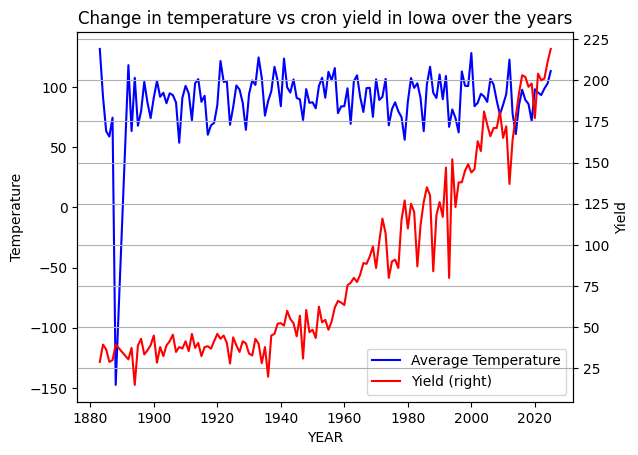

In [137]:
def plot_df(df):
    _, axis = plt.subplots()
    df.plot(x="YEAR", y="Average Temperature", ax=axis, color="blue", label="Average Temperature")
    df.plot(x="YEAR", y="Yield", ax=axis, color="red", label="Yield", secondary_y=True)

    axis.set_ylabel("Temperature")
    axis.right_ax.set_ylabel("Yield")

    plt.title(f"Change in temperature vs cron yield in {STATE.title()} over the years")
    plt.grid(True)
    plt.show()

plot_df(merged_df)